<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/Revised_NN_predict_v34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [1]:
# Bootstraping?? if yes run this cell
#!pip install sdv
#from sdv import SDV
#from sdv.tabular import GaussianCopula

In [2]:
# Importing necesary libraries
# Libraries for correct code execution 
import os, time, joblib, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path
import tensorflow

from sklearn.metrics import r2_score
from scipy import stats
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [3]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [4]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Get working_df

## Find cutoff index

In [5]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [6]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [7]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  #agg_df = aggreagator_v2(df)
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [8]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [9]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  working_df = pd.merge(extra_info_df, data_df, left_index=True, right_index=True)
  return working_df

In [10]:
def main_cutoff(input_path, manual_cutoff=(False, 0.05)):
  print('Reading data from file...')

  data = io.BytesIO(open(input_path, 'rb').read())
  df = pd.read_excel(data, sheet_name='Sheet1', skiprows=1)
  print('Cleaning data...')
  #df.iloc[0].fillna(method='bfill', inplace=True)
  #df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)

  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  df = df.dropna() # remove nan rows

  if manual_cutoff[0] == False:
    cut_point = cut_off_idx(df)
  else:
    #df = aggreagator_v2(df)
    amt_col = df.shape[1]
    m_cutoff_lower = int(amt_col*manual_cutoff[1])
    m_cutoff_upper = int(amt_col-(amt_col*manual_cutoff[1]))
    #cut_point = (m_cutoff_lower, m_cutoff_upper)
  #working_df = select_working_data(df, cut_point)
  working_df = df
  return working_df

## Run main cutoff

In [11]:
'''
input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"

working_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))
working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)
display(working_df)
'''

'\ninput_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"\n\nworking_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))\nworking_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)\ndisplay(working_df)\n'

# New bootstrap

In [12]:
def train_bootstrap_model(data, distances):
  print('Training synthetic data models...')
  for d in tqdm(distances):
    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    distance_data_df = dist_filtered_working_df.iloc[:, 6:dist_filtered_working_df.shape[1]]

    model = GaussianCopula()
    model.fit(distance_data_df)
    model.save(path+'/Spectrum/NN/revised_bootstrap_models/new_revision/model_'+str(d)+'.pkl')
  print('Done')

In [13]:
def generate_new_data(data, amt_desired_data, distances, model_path):
  print('Generating synthetic data samples...')
  headers = list(data.columns)
  loop_cnt = 1
  for d in tqdm(distances):
    loaded_model = SDV.load(model_path+'model_'+str(d)+'.pkl')

    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    dist_filtered_working_df.drop(['PBRS_id'], axis = 1, inplace=True)
    seq = [x for x in range(1, dist_filtered_working_df.shape[0]+1)]
    dist_filtered_working_df.insert(0, 'PBRS_id', seq)

    amt_of_samples_dist = dist_filtered_working_df.shape[0]
    amt_of_new_data = amt_desired_data - amt_of_samples_dist

    if amt_of_new_data > 0: # check if we already have the desired amt of samples
      sample = loaded_model.sample(amt_of_new_data)

      row_data = []
      PBRS_id_data = []
      Distance_km_data = []
      power_dBm_data = []
      span_data = []
      extra_h = ['row', 'PBRS_id', 'Channels', 'Distance_km', 'power_dBm', '#span']
      new_data = {header:[] for header in extra_h}
      id_cnt = dist_filtered_working_df['PBRS_id'].max()+1
      # Create extra info columns
      for i in range(0, amt_of_new_data):
        new_data['row'].append(i+1)
        new_data['PBRS_id'].append(int(id_cnt))
        id_cnt += 1
        new_data['Channels'].append(1)
        new_data['Distance_km'].append(int(d))
        new_data['power_dBm'].append(0)
        new_data['#span'].append(int(d/80))
      new_data_extra_info_df = pd.DataFrame.from_dict(new_data)

      new_data_full_df = pd.merge(new_data_extra_info_df, sample, left_index=True, right_index=True)
      if loop_cnt == 1:
        new_working_df = data.append(new_data_full_df)
        loop_cnt+=1
      else:
        new_working_df = new_working_df.append(new_data_full_df)

    else:
      new_working_df = data.copy()
      print('Amount of desired data already satisfied for distance '+str(d)+'.')


  new_working_df.drop(['row'], axis = 1, inplace=True)

  new_working_df['Distance_km'] = new_working_df['Distance_km'].astype(int)
  new_working_df['PBRS_id'] = new_working_df['PBRS_id'].astype(int)
  new_working_df['Channels'] = new_working_df['Channels'].astype(int)
  new_working_df['power_dBm'] = new_working_df['power_dBm'].astype(int)
  new_working_df['#span'] = new_working_df['#span'].astype(int)

  seq = [x for x in range(1, new_working_df.shape[0]+1)]
  new_working_df.insert(0, 'row', seq)
  new_working_df = new_working_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  new_working_df.to_csv(path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-"+str(amt_desired_data)+"_samples.csv", index=False)

  return new_working_df

In [14]:
'''
distances = [x*80 for x in range(1, 26)]

train_bootstrap_model(working_df, distances)
'''

'\ndistances = [x*80 for x in range(1, 26)]\n\ntrain_bootstrap_model(working_df, distances)\n'

In [15]:
'''
input_path = path + "/Spectrum/NN/new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

amt_desired_data = 100
distances = [x*80 for x in range(1, 26)]
model_path = path+'/Spectrum/NN/revised_bootstrap_models/new_revision/'

new_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)
new_working_df
'''

'\ninput_path = path + "/Spectrum/NN/new_data_working_df.csv"\nworking_df = pd.read_csv(input_path)\nworking_df[\'Distance_km\'] = working_df[\'Distance_km\'].astype(int)\n\namt_desired_data = 100\ndistances = [x*80 for x in range(1, 26)]\nmodel_path = path+\'/Spectrum/NN/revised_bootstrap_models/new_revision/\'\n\nnew_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)\nnew_working_df\n'


# New version train test split

## Freq filter

In [16]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0,1]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  split_span = int(span_val/2)
  span_increase = 0
  for i in range(0, num_selected_freq):
    if i == 0 :
      df2 = data_df.iloc[:, split_span].to_frame()
      new_df = df2
      span_increase = split_span + span_val
    else:
      df2 = data_df.iloc[:, span_increase].to_frame()
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
      span_increase = span_increase + span_val
  new_df = info_df.join(new_df)
  
  return new_df

def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 2000):
  X=None
  Y=np.array([])
  id_df = working_df.iloc[:, 1]
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]

  id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
  samples_df = pd.merge(id_dist_df, freq_df, left_index=True, right_index=True)

  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 1].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 2:samples_df.shape[1]]
  
  return X, Y, samples_df

In [17]:
'''
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)
samples_filtered_df
'''

'\ndistances = [x*80 for x in range(1, 26)]\nX, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)\nsamples_filtered_df\n'

## Reference split

In [18]:
def get_reference_and_sample_data_split(samples_filtered_df, num_reference=30):
  import random
  num_of_ids = len(samples_filtered_df['PBRS_id'].unique())

  l = list(range(1, num_of_ids+1))
  random.shuffle(l)
  reference_arr = (l[:num_reference]) # selecting first "num_reference" random values
  sample_arr = l[-(num_of_ids-num_reference):]

  reference_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(reference_arr)]
  sample_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(sample_arr)]
  reference_data_df = reference_data_df.sort_values(by='PBRS_id')
  sample_data_df = sample_data_df.sort_values(by='PBRS_id')

  reference_data_df = reference_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])
  sample_data_df = sample_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  return reference_data_df, sample_data_df

In [19]:
#reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=30)
#sample_freq_data_df

## features calc

In [20]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(range(0, sample_freq_data_df.shape[0])):
    data_Y = sample_freq_data_df.iloc[row_idx,1] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,2:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()
  
    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,2:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  if ci == False:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max}
  else:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max,
                    'delta_CI_min':data_CI_lower,
                    'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)
  
  return data_df

In [21]:
'''
test_references_params=(False, [80, 1040, 2000])

features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)
features_df
'''

'\ntest_references_params=(False, [80, 1040, 2000])\n\nfeatures_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)\nfeatures_df\n'

## train_test split

In [22]:
def train_and_test_split_funct(features_df, test_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(features_df.values[:, 1:features_df.values.shape[1]], features_df.values[:, 0], test_size=test_size, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)
  
  joblib.dump(data_scaler, path+'/Spectrum/NN/revised_NNs/scaler_nn.joblib')

  return x_train, y_train, x_test, y_test, data_scaler

In [23]:
#x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=0.2)

## main features train_test

In [24]:
def main_features_train_test_split(input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    #samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    
    reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [25]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)
'''

'\ninput_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"\n\nx_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(\n    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)\n'

#Test new data

In [ ]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=0.05, params_freq_reference = (10, 30), all_plots=True, epochs_num=600, training_data=False, save_res=False):
  print('Results (freq_'+str(params_freq_reference[0])+'_reference_'+str(params_freq_reference[1])+')')
  # Predit

  Y_test_pred=model_ann.predict(X_test)

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred=list(Y_test_pred)
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  '''
  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)
  '''
  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  num_of_remove_items = len(real) * remove_outliers

  filtered_real_abs = real_abs
  filtered_pred_abs = pred_abs
  error_v2_filtered = error_v2
  error_filtered = error
  remove_cnt = 0
  while remove_cnt <= num_of_remove_items:
    max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
    max_idx = max_idx[0][0]
    error_v2_filtered = np.delete(error_v2_filtered, max_idx)
    filtered_real_abs = np.delete(filtered_real_abs, max_idx)
    filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
    error_filtered = np.delete(error_filtered, max_idx)
    remove_cnt += 1

  if all_plots == True:
    if save_res == True:
      res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
      res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)

      res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)
      
      plt.plot(real_abs,error,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Curve (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
      
      plt.plot(real_abs,error_v2,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Deltas (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")

      # Filtered Outliers
      plt.plot(filtered_real_abs,error_v2_filtered,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.figure(figsize=(20,10))
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances')
    labels = [i*80 for i in range(1, 26)]
    plt.xticks(labels)
    #plt.yticks(labels) 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    if save_res == True:
      if training_data == False:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")   
      else:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")
    plt.show()

  return error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs

## Only Features

In [ ]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    #samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    
    reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 5, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = False # include or exclude CI calc
parameters_freq_reference = ('all', 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1755/1755 [02:06<00:00, 13.88it/s]



Obtaining train and test split...
Done


Training model (freq_all_reference_30)...
INFO:tensorflow:Assets written to: ram://30abc17a-ebeb-4b8f-b56e-d9f2b77209e2/assets


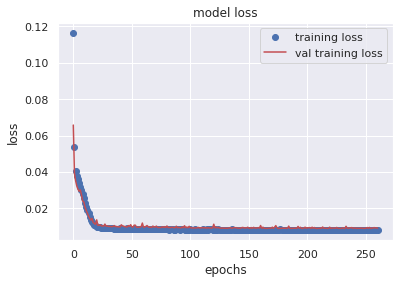

In [ ]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])


Results (freq_all_reference_30)


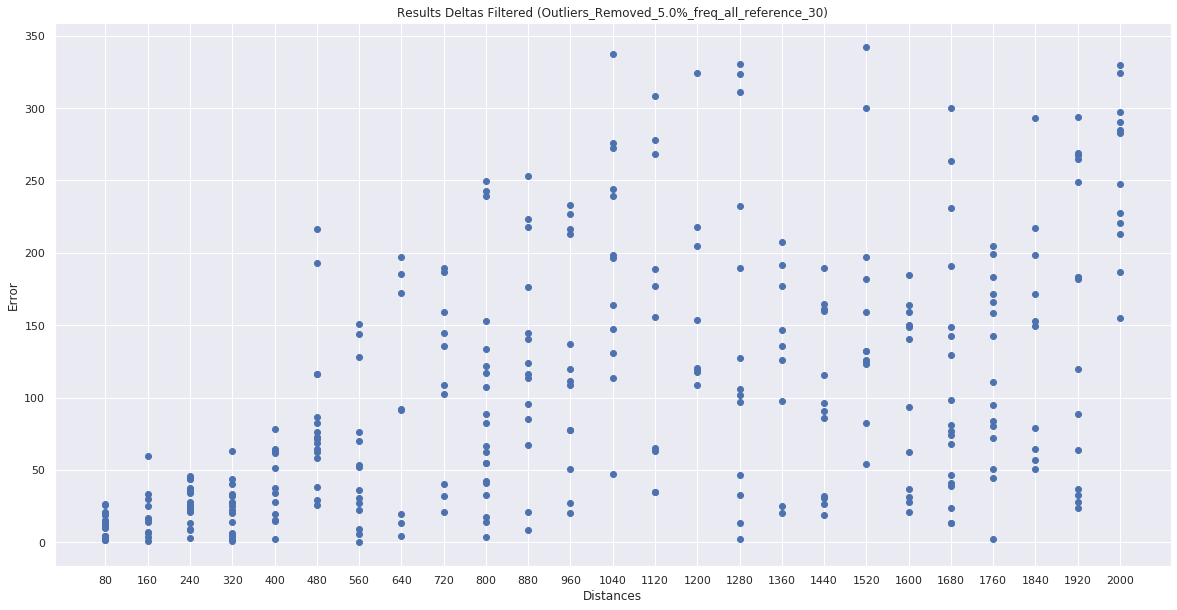

In [ ]:
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=False, epochs_num='test', training_data=False, save_res=False)

In [ ]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.908
The R2 score on the Test set is:	0.925


,actual,pred,error
21,1.0,0.852673,0.147327
38,1.0,0.828353,0.171647
44,1.0,0.889013,0.110987
59,1.0,0.769386,0.230614
65,1.0,0.885025,0.114975
125,1.0,0.871035,0.128965
155,1.0,0.851532,0.148468
184,1.0,0.919109,0.080891
215,1.0,0.902845,0.097155
227,1.0,0.767146,0.232854


In [ ]:

#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')


,actual,pred,error
21,2000.0,1717.132324,282.867676
38,2000.0,1670.437866,329.562134
44,2000.0,1786.904785,213.095215
59,2000.0,1557.220825,442.779175
65,2000.0,1779.248535,220.751465
125,2000.0,1752.386230,247.613770
155,2000.0,1714.941040,285.058960
184,2000.0,1844.688965,155.311035
215,2000.0,1813.462036,186.537964
227,2000.0,1552.920776,447.079224


## all data points

In [38]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=0.05, params_freq_reference = (10, 30), all_plots=True, epochs_num=600, training_data=False, save_res=False):
  print('Results (freq_'+str(params_freq_reference[0])+'_reference_'+str(params_freq_reference[1])+')')
  # Predit

  Y_test_pred=model_ann.predict(X_test)

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred=list(Y_test_pred)
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  '''
  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)
  '''
  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  num_of_remove_items = len(real) * remove_outliers

  filtered_real_abs = real_abs
  filtered_pred_abs = pred_abs
  error_v2_filtered = error_v2
  error_filtered = error
  remove_cnt = 0
  while remove_cnt <= num_of_remove_items:
    max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
    max_idx = max_idx[0][0]
    error_v2_filtered = np.delete(error_v2_filtered, max_idx)
    filtered_real_abs = np.delete(filtered_real_abs, max_idx)
    filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
    error_filtered = np.delete(error_filtered, max_idx)
    remove_cnt += 1

  if all_plots == True:
    if save_res == True:
      res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
      res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)

      res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Curve (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error_v2,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Deltas (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()

      # Filtered Outliers
      plt.figure(figsize=(20,10))      
      plt.plot(filtered_real_abs,error_v2_filtered,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)
      plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.figure(figsize=(20,10))
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances')
    labels = [i*80 for i in range(1, 26)]
    plt.xticks(labels)
    #plt.yticks(labels) 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    if save_res == True:
      if training_data == False:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")   
      else:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")
    plt.show()

  return error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs

In [27]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    #reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    #features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [28]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 2561, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [29]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = True # include or exclude CI calc
parameters_freq_reference = ('all', 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...

Obtaining train and test split...
Done


Training model (freq_all_reference_30)...
INFO:tensorflow:Assets written to: ram://5c514c88-4db3-4439-984b-0c8091d9b320/assets


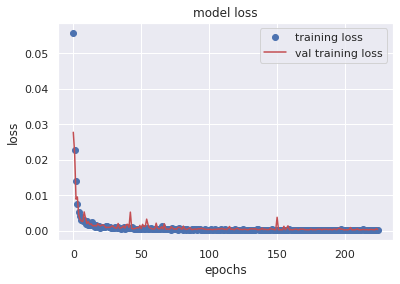

In [30]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])


Results (freq_all_reference_30)


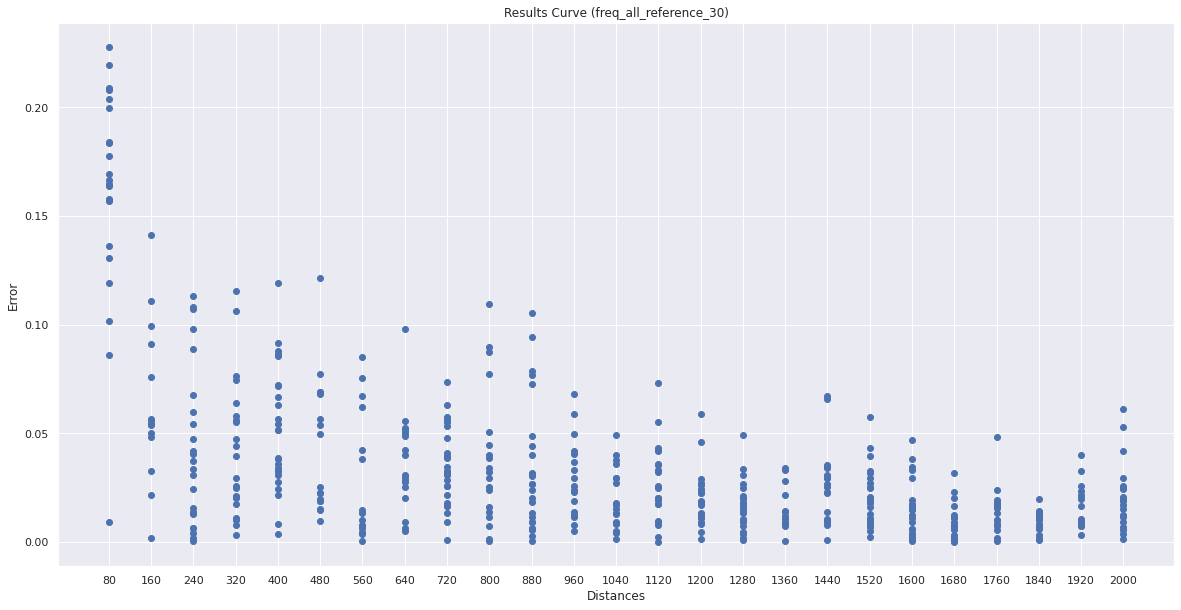

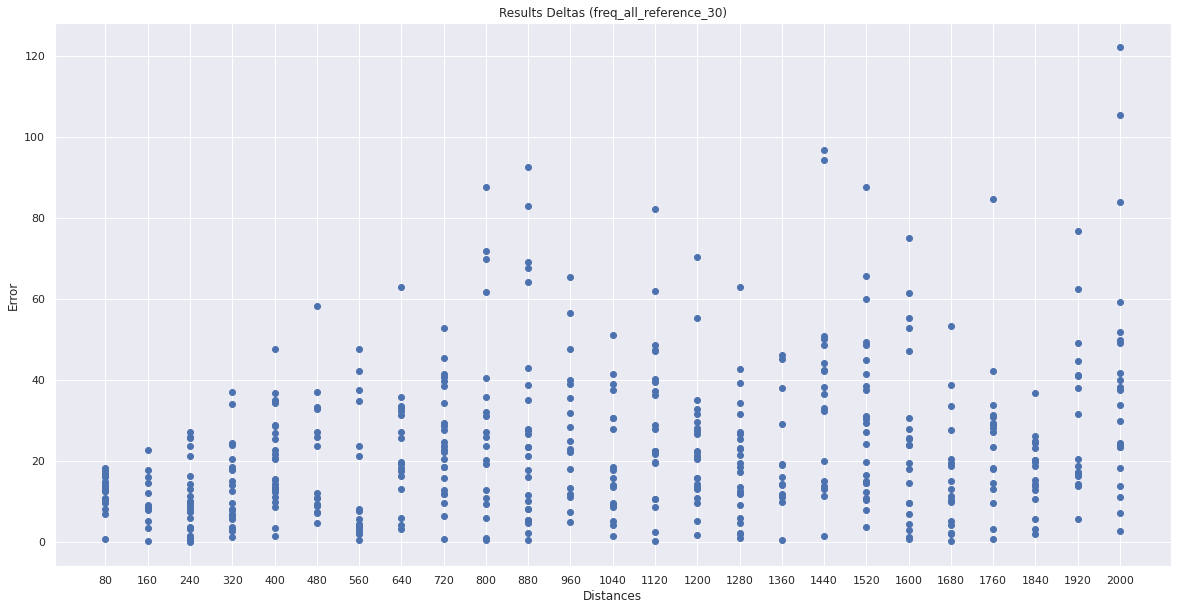

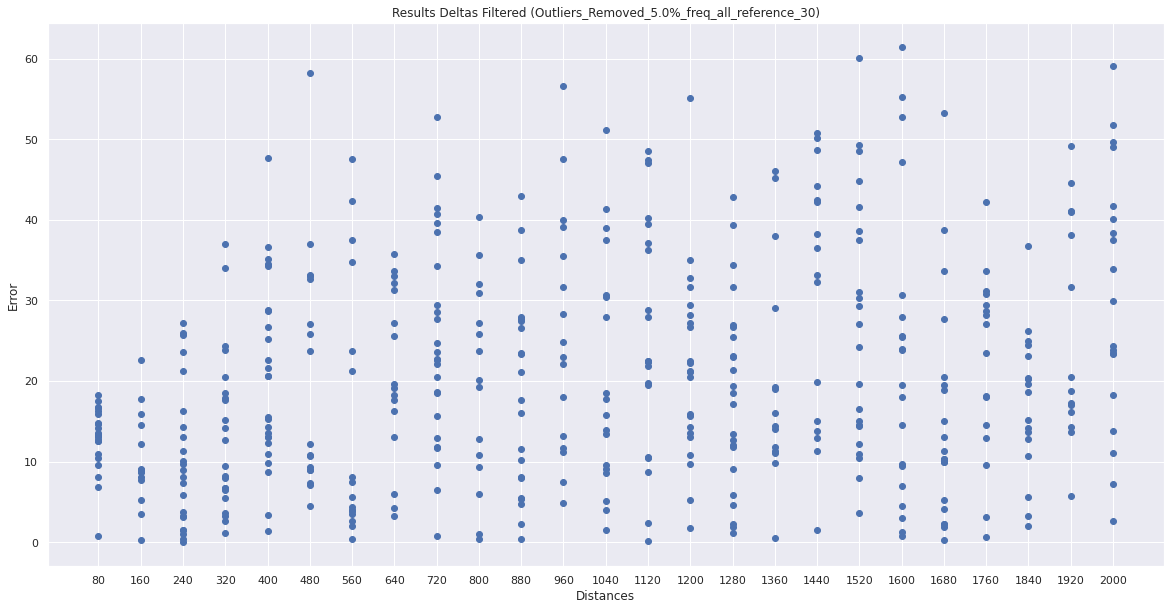

In [39]:
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=True, epochs_num='test', training_data=False, save_res=True)

In [32]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	0.997


,actual,pred,error
30,1.0,0.973066,0.026934
41,1.0,0.992827,0.007173
73,1.0,0.979141,0.020859
84,1.0,0.936450,0.063550
102,1.0,0.996242,0.003758
131,1.0,0.969206,0.030794
138,1.0,0.974483,0.025517
176,1.0,0.956380,0.043620
188,1.0,0.994242,0.005758
215,1.0,0.984416,0.015584


In [62]:
def threshold_review(y_test_norm, y_test_pred, threshold = 60, min=80, max=2000):
  y_test_denorm = (y_test_norm * (max-min)+min)
  y_test_pred_denorm = (y_test_pred * (max-min)+min)

  # inverted_x_test = scaler.inverse_transform(x_test)
  df = pd.DataFrame(y_test_denorm, columns=['actual'])
  df.insert(1, 'pred', y_test_pred_denorm)
  df.insert(2, 'error', (abs(df.actual-df.pred)))
  df['above_threshold'] = np.where(df['error'] > threshold, 1, 0)
  
  num_of_accepted_vals = df.groupby('above_threshold')['above_threshold'].count()[0]
  num_of_rejected_vals = df.groupby('above_threshold')['above_threshold'].count()[1]
  total_amt_of_data = len(df)

  accuracy = round((num_of_accepted_vals/total_amt_of_data), 2)

  return df, accuracy*100

In [63]:

res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = 60)
#res_predictions.query('actual == 2000.0')

print('Accuracy is: '+str(accuracy)+'%')

Accuracy is: 94.0%


### graph avg error

## only 100 freq

In [ ]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    #reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    #features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 100, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = True # include or exclude CI calc
parameters_freq_reference = (100, 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...

Obtaining train and test split...
Done


Training model (freq_100_reference_30)...
INFO:tensorflow:Assets written to: ram://45dade3b-9824-4485-92ee-d2b46bcc8979/assets


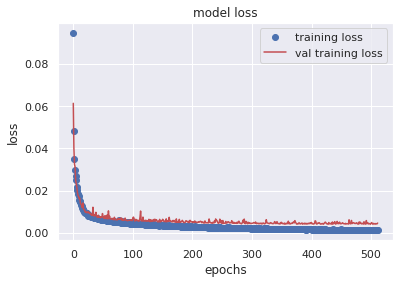

In [ ]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])


Results (freq_100_reference_30)


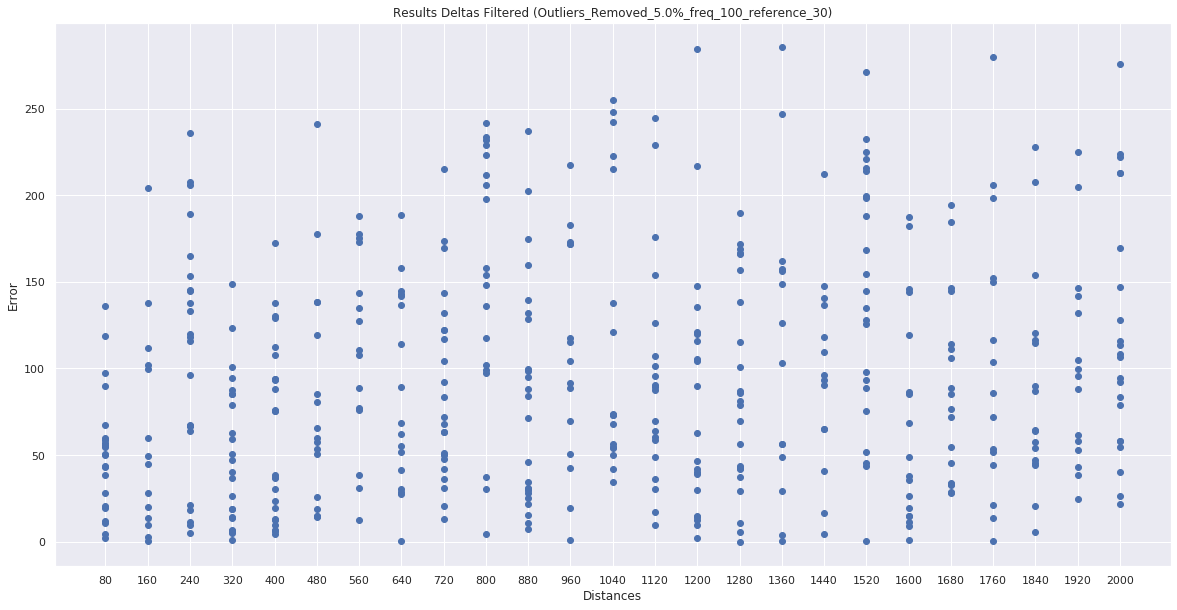

In [ ]:
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=False, epochs_num='test', training_data=False, save_res=False)

In [ ]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.978
The R2 score on the Test set is:	0.944


,actual,pred,error
30,1.0,0.943648,0.056352
41,1.0,0.979122,0.020878
73,1.0,1.115519,-0.115519
84,1.0,0.889154,0.110846
102,1.0,0.856323,0.143677
131,1.0,0.911557,0.088443
138,1.0,1.041013,-0.041013
176,1.0,0.969693,0.030307
188,1.0,0.883601,0.116399
215,1.0,0.923563,0.076437


In [ ]:

#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')


,actual,pred,error
30,2000.0,1891.804810,108.195190
41,2000.0,1959.913574,40.086426
73,2000.0,2221.796631,-221.796631
84,2000.0,1787.175537,212.824463
102,2000.0,1724.140015,275.859985
131,2000.0,1830.188721,169.811279
138,2000.0,2078.744629,-78.744629
176,2000.0,1941.810425,58.189575
188,2000.0,1776.513672,223.486328
215,2000.0,1853.241821,146.758179


## test best combination

In [ ]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    #reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    #features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(41, input_dim = 2561, activation = 'tanh'))
  model.add(Dense(153,activation='tanh'))
  model.add(Dense(73,activation='tanh'))
  model.add(Dense(169,activation='tanh'))
  model.add(Dense(249,activation='tanh'))  
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = True # include or exclude CI calc
parameters_freq_reference = ('all', 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...

Obtaining train and test split...
Done


Training model (freq_all_reference_30)...
INFO:tensorflow:Assets written to: ram://fc9952f8-2bdf-4250-b4f5-5b839e08123e/assets


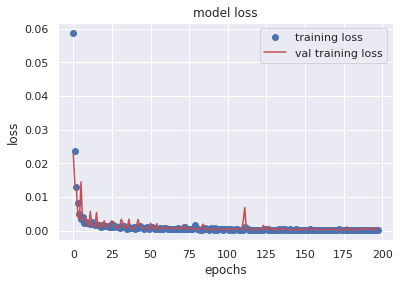

In [ ]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])


Results (freq_all_reference_30)


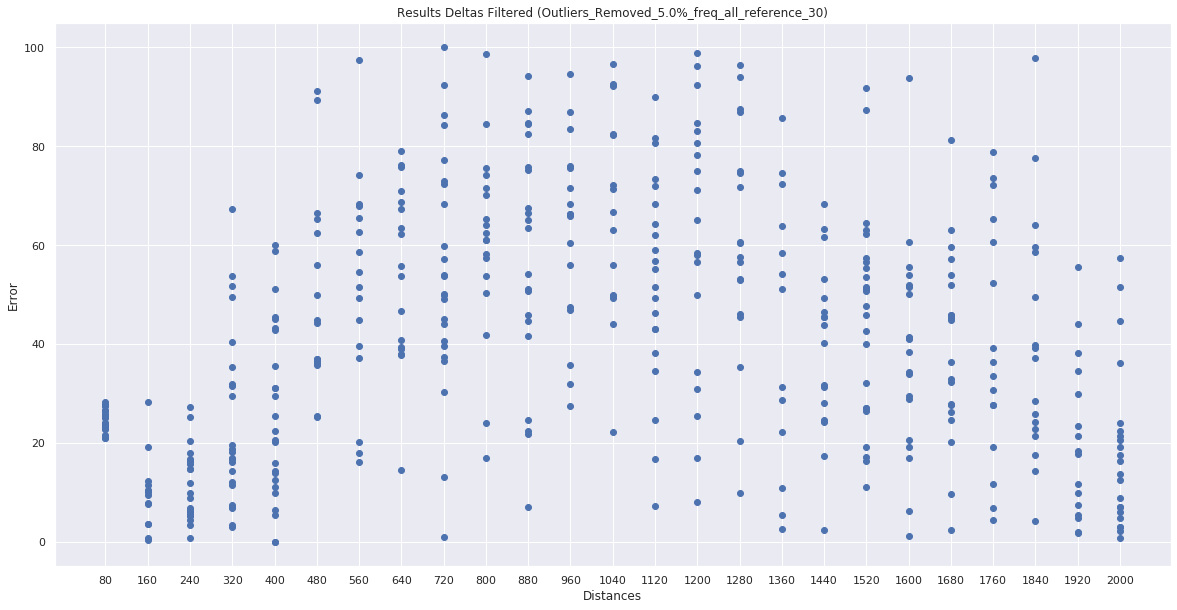

In [ ]:
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=False, epochs_num='test', training_data=False, save_res=False)

In [ ]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.992
The R2 score on the Test set is:	0.991


,actual,pred,error
30,1.0,1.001497,-0.001497
41,1.0,1.023229,-0.023229
73,1.0,0.998467,0.001533
84,1.0,0.973206,0.026794
102,1.0,0.996377,0.003623
131,1.0,0.993525,0.006475
138,1.0,0.997466,0.002534
176,1.0,0.989332,0.010668
188,1.0,0.981220,0.018780
215,1.0,1.008493,-0.008493


In [ ]:

#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')


,actual,pred,error
30,2000.0,2002.873657,-2.873657
41,2000.0,2044.599243,-44.599243
73,2000.0,1997.057007,2.942993
84,2000.0,1948.555542,51.444458
102,2000.0,1993.042969,6.957031
131,2000.0,1987.568604,12.431396
138,2000.0,1995.134399,4.865601
176,2000.0,1979.516968,20.483032
188,2000.0,1963.943359,36.056641
215,2000.0,2016.306641,-16.306641


## combine feature and all data

In [ ]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')    
    reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
   
    sample_freq_data_df.reset_index(inplace = True)
    sample_freq_data_df = sample_freq_data_df.iloc[: , 1:]

    print('Calculating features...')
    features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    features_df = features_df.iloc[: , 1:]
    sample_freq_data_df = sample_freq_data_df.iloc[: , 1:]

    comb_df = pd.merge(sample_freq_data_df, features_df, left_index=True, right_index=True)

    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(comb_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 505, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = False # include or exclude CI calc
parameters_freq_reference = (500, 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1760/1760 [01:11<00:00, 24.67it/s]



Obtaining train and test split...
Done


Training model (freq_500_reference_30)...
INFO:tensorflow:Assets written to: ram://cfe256f6-301f-4d56-9d90-97d3dfee68ec/assets


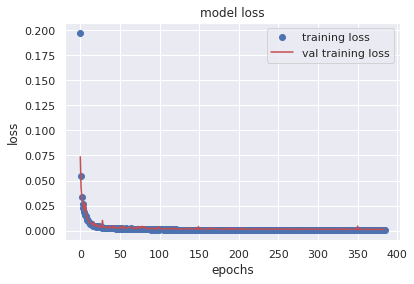

In [ ]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])


Results (freq_500_reference_30)


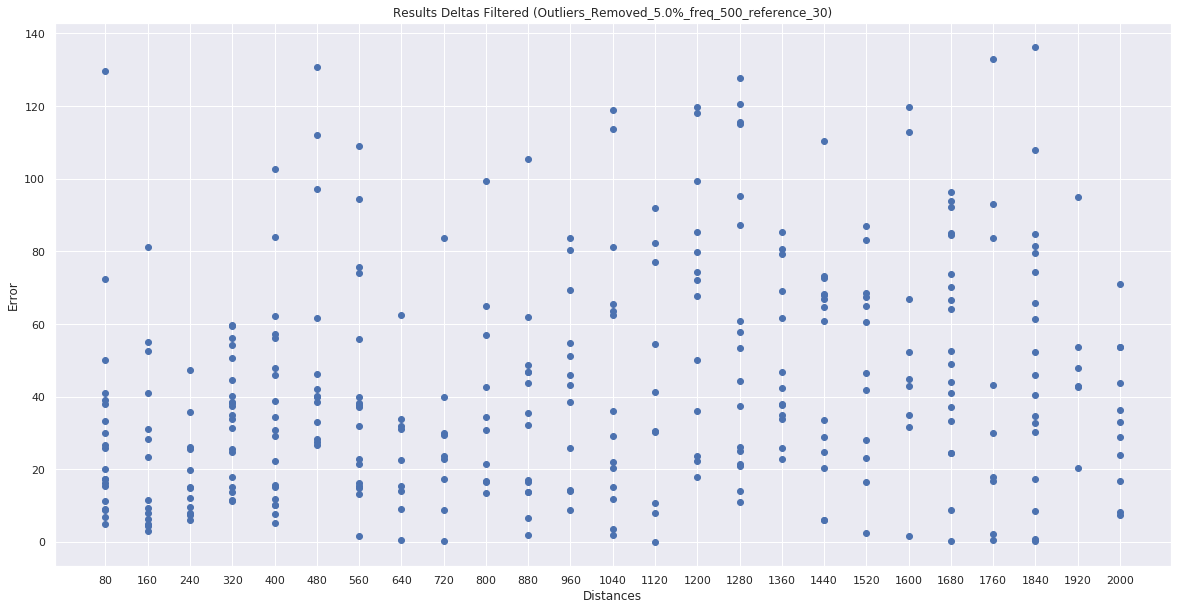

In [ ]:
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=False, epochs_num='test', training_data=False, save_res=False)

In [ ]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.996
The R2 score on the Test set is:	0.988


,actual,pred,error
1,1.0,0.914546,0.085454
4,1.0,0.984934,0.015066
14,1.0,0.963035,0.036965
39,1.0,1.027919,-0.027919
74,1.0,1.027977,-0.027977
135,1.0,1.017269,-0.017269
227,1.0,0.995759,0.004241
231,1.0,1.008737,-0.008737
232,1.0,0.996147,0.003853
257,1.0,0.977178,0.022822


In [ ]:

#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')


,actual,pred,error
1,2000.0,1835.928467,164.071533
4,2000.0,1971.074097,28.925903
14,2000.0,1929.027100,70.972900
39,2000.0,2053.604492,-53.604492
74,2000.0,2053.715576,-53.715576
135,2000.0,2033.155762,-33.155762
227,2000.0,1991.858154,8.141846
231,2000.0,2016.774536,-16.774536
232,2000.0,1992.602661,7.397339
257,2000.0,1956.182007,43.817993


## random search

In [ ]:
!pip install keras-tuner -q

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras import optimizers

In [ ]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    #working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    #reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    #features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [ ]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

ci = True # include or exclude CI calc
parameters_freq_reference = ('all', 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, multiplier=1, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...

Obtaining train and test split...
Done


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(hp.Int('units_0', min_value=9, max_value=512, step=16), input_dim = 2561, activation="tanh"))
    for i in range(1, hp.Int('num_layers', 1, 8)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int('units_' + str(i), min_value=9, max_value=512, step=16),
                activation="tanh"),
        )
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [ ]:
import os.path 
for i in range(0, 20):
  tunner_path = path+"/Spectrum/NN/revised_NNs/tunner_search_"+str(i)
  isdir = os.path.isdir(tunner_path) 
  if isdir == False:
    dir_tunner = tunner_path
    break

tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory=dir_tunner,
    project_name='Dist predictor')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 9, 'max_value': 512, 'step': 16, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
print('Evaluating hyperparameters...')
tuner.search(x_train, y_train_norm,
             epochs=200,
             validation_data=(x_test, y_test_norm), verbose=0)
print('Done')

print('-------------------------------------')
tuner.results_summary()

Evaluating hyperparameters...
INFO:tensorflow:Oracle triggered exit
Done
-------------------------------------
Results summary
Results in /content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/Spectrum/NN/revised_NNs/tunner_search_4/Dist predictor
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 41
num_layers: 5
learning_rate: 0.0001
units_1: 153
units_2: 73
units_3: 169
units_4: 249
Score: 0.0007779208826832473
Trial summary
Hyperparameters:
units_0: 41
num_layers: 2
learning_rate: 0.0001
units_1: 297
units_2: 105
units_3: 489
units_4: 281
Score: 0.0008362882460157076
Trial summary
Hyperparameters:
units_0: 313
num_layers: 4
learning_rate: 0.0001
units_1: 409
units_2: 105
units_3: 153
units_4: 25
Score: 0.0014347647471974294
Trial summary
Hyperparameters:
units_0: 377
num_layers: 5
learning_rate: 0.01
units_1: 9
units_2: 9
units_3: 9
units_4: 9
Score: 0.08852744847536087
Trial summary
Hyperparameters:
units_0: 249
num_layers: 4
learning_rate: 0.001
units_1: 377
units_2: 

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(5))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                105042    
                                                                 
 dense_1 (Dense)             (None, 153)               6426      
                                                                 
 dense_2 (Dense)             (None, 73)                11242     
                                                                 
 dense_3 (Dense)             (None, 169)               12506     
                                                                 
 dense_4 (Dense)             (None, 249)               42330     
                                                                 
 dense_5 (Dense)             (None, 1)                 250       
                                                                 
Total params: 177,796
Trainable params: 177,796
Non-trai

## test model

------------------Trainig------------------
Epoch 35: early stopping
The R2 score on the Train set is:	-3.251
The R2 score on the Test set is:	-3.228


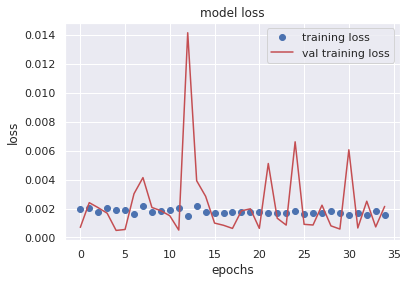

In [ ]:
#Fits model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
print('------------------Trainig------------------')
history = best_model.fit(x_train, y_train_norm, epochs = 5000, validation_split = 0.2, batch_size=32, callbacks = [earlystop], shuffle = True, verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'val training loss'], loc='best')

# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

# train best than test overfitting

Text(0, 0.5, 'Error')

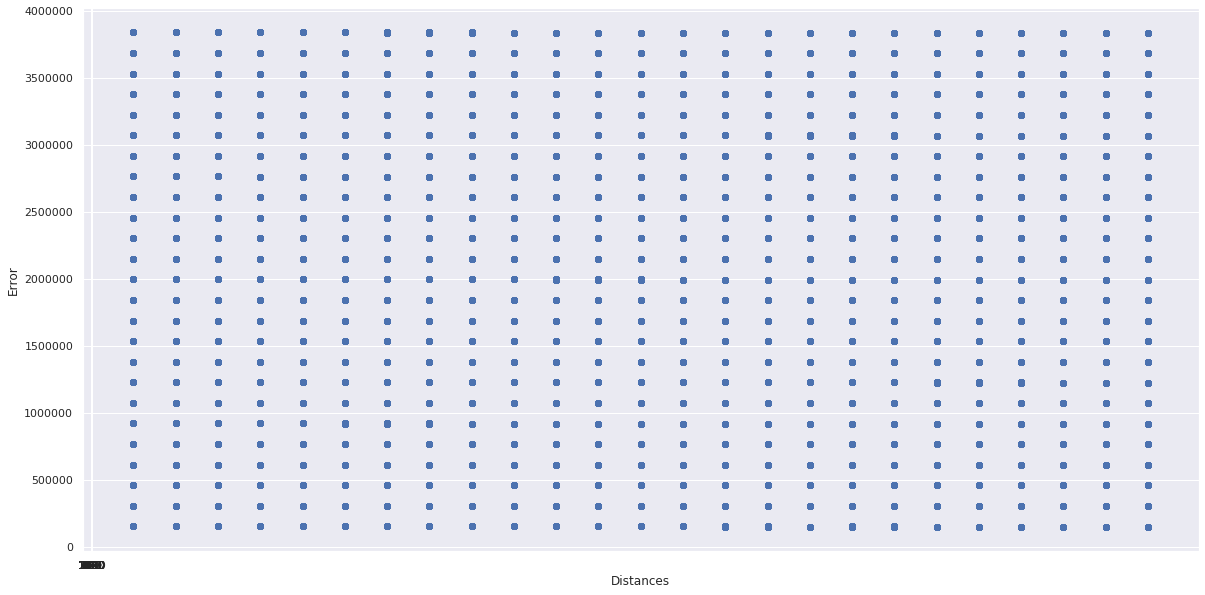

In [ ]:
Y_test_pred=best_model.predict(x_test)

dist_min=80
dist_max=2000

real=list(y_test)
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]

pred=list(Y_test_pred)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred))

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

plt.figure(figsize=(20,10))
plt.plot(real_abs,error_v2,'bo')
plt.xlabel('Distances')
labels = [i*80 for i in range(1, 26)]
plt.xticks(labels)
#plt.yticks(labels) 
plt.ylabel('Error') 

In [ ]:
# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 1.0')

,actual,pred,error
30,1.0,0.987551,0.012449
41,1.0,1.026365,-0.026365
73,1.0,0.992498,0.007502
84,1.0,0.952496,0.047504
102,1.0,1.018022,-0.018022
131,1.0,0.990564,0.009436
138,1.0,1.007206,-0.007206
176,1.0,1.006714,-0.006714
188,1.0,1.009317,-0.009317
215,1.0,1.023871,-0.023871


In [ ]:
#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')

,actual,pred,error
30,2000.0,1976.097290,23.902710
41,2000.0,2050.620117,-50.620117
73,2000.0,1985.595947,14.404053
84,2000.0,1908.792847,91.207153
102,2000.0,2034.601685,-34.601685
131,2000.0,1981.883057,18.116943
138,2000.0,2013.834961,-13.834961
176,2000.0,2012.891357,-12.891357
188,2000.0,2017.888428,-17.888428
215,2000.0,2045.832275,-45.832275
